这张图展示了一个名为"Path Planning Transformers (PPT)"的路径规划系统，它是一个为移动机器人设计的、由改进版RRT*算法监督的路径规划转换器。我来详细解释这个系统的工作流程：

1. 路径规划任务（Path-planning Task）
- 输入包括：起始点（蓝色方块）、目标点（绿色方块）和地图环境
- 地图中的黑色区域代表障碍物

2. 模型构建和训练（Model Construction and Training）
- 系统使用480×480像素的随机森林地图生成样本
- 将地图尺寸缩减到224×224像素并进行分块处理
- 每个分块大小为32×32像素，总共49个分块
- 使用IRRT-RRMS（改进的快速随机树算法）生成解决方案
- 将解决方案转换为CSV文件格式

3. 解决方案预测（Solution Prediction）
- 使用Path Planning Transformer (PPT)模型进行预测
- 模型输入包括坐标(X, Y)和类型信息（起点、终点、中间点）
- 通过迭代方式生成路径点，直到达到停止点

4. 路径规划解决方案（Path-planning Solution）
- 如果需要，使用细菌突变和节点删除算法进行后处理优化
- 最终输出包括中间点和完整的解决方案路径（红线）

这个系统的创新之处在于：
- 结合了深度学习（Transformer架构）和传统路径规划算法（RRT*）
- 通过降低随机地图大小来提高效率
- 使用分块处理来处理复杂环境
- 包含后处理优化步骤以改善路径质量

该方法可以有效地为移动机器人在复杂环境中规划出避开障碍物的最优路径。


# 构建数据集

1. 随机森林地图生成与标注
使用算法生成随机森林地图。
地图尺寸为480×480像素。
地图需要包含明确的起始点（蓝色方块）、目标点（绿色方块）以及障碍物区域（黑色区域）。
根据生成的地图，使用IRRT-RRMS算法（改进的快速随机树算法）生成路径解决方案。
确保解决方案包含所有路径点（包括起点、终点、中间点）。

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import random
from scipy.spatial import KDTree
from dataclasses import dataclass
from typing import List, Tuple, Dict
import yaml
import logging

# 配置日志记录
logging.basicConfig(
    level=logging.INFO,  # 设置日志等级为 INFO
    format='%(asctime)s - %(levelname)s - %(message)s',  # 日志格式
    handlers=[logging.StreamHandler()]  # 输出到控制台
)



In [8]:
@dataclass
class MapConfig:
    size: int = 480
    num_obstacles: int = 50
    marker_size: int = 15
    clearance: int = 20
    output_dir: str = "output"
    num_maps: int = 100
    step_size: int = 15
    max_iterations: int = 2000

class Obstacle:
    def is_collision(self, point: np.ndarray) -> bool:
        raise NotImplementedError

    def to_dict(self) -> dict:
        raise NotImplementedError

class CircleObstacle(Obstacle):
    def __init__(self, center: Tuple[float, float], radius: float):
        self.center = np.array(center, dtype=float)
        self.radius = radius

    def is_collision(self, point: np.ndarray) -> bool:
        return np.linalg.norm(point - self.center) < self.radius

    def to_dict(self) -> dict:
        return {'x': self.center[0], 'y': self.center[1], 'shape': 'circle', 'radius': self.radius}

class RectangleObstacle(Obstacle):
    def __init__(self, x: float, y: float, width: float, height: float):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

    def is_collision(self, point: np.ndarray) -> bool:
        return self.x <= point[0] <= self.x + self.width and self.y <= point[1] <= self.y + self.height

    def to_dict(self) -> dict:
        return {'x': self.x, 'y': self.y, 'shape': 'rectangle', 'width': self.width, 'height': self.height}


In [4]:
class IRRT_RRMS:
    def __init__(self, start: np.ndarray, goal: np.ndarray, obstacles: List[Obstacle], config: MapConfig):
        self.start = start
        self.goal = goal
        self.obstacles = obstacles
        self.config = config
        self.nodes = [start]
        self.parents = {tuple(start): None}
        self.kdtree = KDTree([start])

    def is_collision_free(self, point: np.ndarray) -> bool:
        if not (0 <= point[0] <= self.config.size and 0 <= point[1] <= self.config.size):
            return False
        return all(not obs.is_collision(point) for obs in self.obstacles)

    def is_path_collision_free(self, start: np.ndarray, end: np.ndarray) -> bool:
        direction = end - start
        distance = np.linalg.norm(direction)
        steps = int(distance / 5) + 1
        for i in range(steps):
            point = start + direction * (i / steps)
            if not self.is_collision_free(point):
                return False
        return True

    def find_path(self) -> List[Tuple[float, float]]:
        for _ in range(self.config.max_iterations):
            rand_point = self.goal if random.random() < 0.1 else np.random.uniform(0, self.config.size, 2)
            _, idx = self.kdtree.query(rand_point)
            nearest_node = self.nodes[idx]
            direction = rand_point - nearest_node
            distance = np.linalg.norm(direction)
            if distance > self.config.step_size:
                direction = direction / distance * self.config.step_size
            new_node = nearest_node + direction

            if self.is_collision_free(new_node) and self.is_path_collision_free(nearest_node, new_node):
                self.nodes.append(new_node)
                self.parents[tuple(new_node)] = tuple(nearest_node)
                self.kdtree = KDTree(self.nodes)

                if np.linalg.norm(new_node - self.goal) < self.config.step_size:
                    self.parents[tuple(self.goal)] = tuple(new_node)
                    return self.reconstruct_path()
        return []

    def reconstruct_path(self) -> List[Tuple[float, float]]:
        path = [tuple(self.goal)]
        current = tuple(self.goal)
        while current in self.parents:
            parent = self.parents[current]
            if parent is None:
                break
            path.append(parent)
            current = parent
        return path[::-1]


In [5]:
class PathPlanner:
    def __init__(self, config: MapConfig):
        self.config = config
        self.map_dir = os.path.join(config.output_dir, "maps")
        self.coord_dir = os.path.join(config.output_dir, "coordinates")
        os.makedirs(self.map_dir, exist_ok=True)
        os.makedirs(self.coord_dir, exist_ok=True)

    def generate_maps(self):
        for index in range(1, self.config.num_maps + 1):
            try:
                self.generate_single_map(index)
                print(f"Map {index} generated successfully.")
            except Exception as e:
                print(f"Failed to generate map {index}: {e}")
    def generate_single_map(self, index: int):
      try:
          print(f"Generating map {index}...")

          fig, ax = plt.subplots(figsize=(10, 10))
          ax.set_facecolor('white')
          ax.set_xlim(0, self.config.size)
          ax.set_ylim(0, self.config.size)
          ax.axis('off')

          print(f"Generating obstacles for map {index}...")
          obstacles = []
          for _ in range(self.config.num_obstacles):
              if random.random() < 0.6:
                  radius = random.randint(10, 20)
                  center = (random.randint(radius, self.config.size - radius),
                            random.randint(radius, self.config.size - radius))
                  obstacle = CircleObstacle(center, radius)
              else:
                  size_square = random.randint(20, 30)
                  x = random.randint(0, self.config.size - size_square)
                  y = random.randint(0, self.config.size - size_square)
                  obstacle = RectangleObstacle(x, y, size_square, size_square)

              if all(not obs.is_collision(obstacle.center if isinstance(obstacle, CircleObstacle)
                                        else [x + size_square / 2, y + size_square / 2])
                    for obs in obstacles):
                  obstacles.append(obstacle)
                  if isinstance(obstacle, CircleObstacle):
                      ax.add_patch(Circle(obstacle.center, obstacle.radius, facecolor='black'))
                  else:
                      ax.add_patch(Rectangle((obstacle.x, obstacle.y),
                                            obstacle.width, obstacle.height,
                                            facecolor='black'))

          print(f"Obstacles generated successfully for map {index}.")

          while True:
              start_point = np.random.uniform(0, self.config.size // 3, 2)
              if all(not obs.is_collision(start_point) for obs in obstacles):
                  break

          print(f"Start point for map {index}: {start_point}.")

          while True:
              goal_point = np.random.uniform(2 * self.config.size // 3, self.config.size, 2)
              if all(not obs.is_collision(goal_point) for obs in obstacles):
                  break

          print(f"Goal point for map {index}: {goal_point}.")

          ax.add_patch(Rectangle((start_point[0] - self.config.marker_size / 2,
                                start_point[1] - self.config.marker_size / 2),
                              self.config.marker_size, self.config.marker_size,
                              facecolor='blue'))
          ax.add_patch(Rectangle((goal_point[0] - self.config.marker_size / 2,
                                goal_point[1] - self.config.marker_size / 2),
                              self.config.marker_size, self.config.marker_size,
                              facecolor='green'))

          print(f"Running path planning for map {index}...")
          planner = IRRT_RRMS(start_point, goal_point, obstacles, self.config)
          path = planner.find_path()

          if path:
              path = [[float(x), float(y)] for x, y in path]
              path_array = np.array(path)
              ax.plot(path_array[:, 0], path_array[:, 1], color='red', linewidth=2)
              print(f"Path found for map {index}.")
          else:
              print(f"No path found for map {index}.")

          # 保存地图图像
          map_path = os.path.join(self.map_dir, f"map_{index:02d}.png")
          plt.savefig(map_path, bbox_inches='tight', pad_inches=0, dpi=100)
          plt.close(fig)
          print(f"Map image saved for map {index} at {map_path}.")

          # 保存坐标数据
          coord_data = {

              'start_point': [float(start_point[0]), float(start_point[1])],
              'goal_point': [float(goal_point[0]), float(goal_point[1])],
              'obstacles': [
                  {
                      'shape': 'circle' if isinstance(obs, CircleObstacle) else 'rectangle',
                      'x': float(obs.center[0]) if isinstance(obs, CircleObstacle) else float(obs.x),
                      'y': float(obs.center[1]) if isinstance(obs, CircleObstacle) else float(obs.y),
                      **(
                          {'radius': float(obs.radius)} if isinstance(obs, CircleObstacle)
                          else {'width': float(obs.width), 'height': float(obs.height)}
                      )
                  }
                  for obs in obstacles
              ],
              'path': path if path else []
          }

          coord_path = os.path.join(self.coord_dir, f"coordinates_{index:02d}.yaml")
          with open(coord_path, 'w') as f:
              yaml.safe_dump(coord_data, f, default_flow_style=False, sort_keys=False)
          print(f"Coordinate file saved for map {index} at {coord_path}.")

      except Exception as e:
          print(f"Error generating map {index}: {str(e)}")
          raise


In [6]:
from tqdm import tqdm  # 引入 tqdm 用于显示进度条

class PathPlanner:
    def __init__(self, config: MapConfig):
        self.config = config
        self.map_dir = os.path.join(config.output_dir, "maps")
        self.coord_dir = os.path.join(config.output_dir, "coordinates")
        os.makedirs(self.map_dir, exist_ok=True)
        os.makedirs(self.coord_dir, exist_ok=True)

    def generate_maps(self):
        # 使用 tqdm 包裹范围生成器，显示进度条
        for index in tqdm(range(1, self.config.num_maps + 1), desc="Generating Maps"):
            try:
                self.generate_single_map(index)
                print(f"Map {index} generated successfully.")
            except Exception as e:
                print(f"Failed to generate map {index}: {e}")

    def generate_single_map(self, index: int):
        try:
            #print(f"Generating map {index}...")

            fig, ax = plt.subplots(figsize=(10, 10))
            ax.set_facecolor('white')
            ax.set_xlim(0, self.config.size)
            ax.set_ylim(0, self.config.size)
            ax.axis('off')

            #print(f"Generating obstacles for map {index}...")
            obstacles = []
            for _ in range(self.config.num_obstacles):
                if random.random() < 0.6:
                    radius = random.randint(10, 20)
                    center = (random.randint(radius, self.config.size - radius),
                              random.randint(radius, self.config.size - radius))
                    obstacle = CircleObstacle(center, radius)
                else:
                    size_square = random.randint(20, 30)
                    x = random.randint(0, self.config.size - size_square)
                    y = random.randint(0, self.config.size - size_square)
                    obstacle = RectangleObstacle(x, y, size_square, size_square)

                if all(not obs.is_collision(obstacle.center if isinstance(obstacle, CircleObstacle)
                                           else [x + size_square / 2, y + size_square / 2])
                      for obs in obstacles):
                    obstacles.append(obstacle)
                    if isinstance(obstacle, CircleObstacle):
                        ax.add_patch(Circle(obstacle.center, obstacle.radius, facecolor='black'))
                    else:
                        ax.add_patch(Rectangle((obstacle.x, obstacle.y),
                                              obstacle.width, obstacle.height,
                                              facecolor='black'))

            #print(f"Obstacles generated successfully for map {index}.")

            while True:
                start_point = np.random.uniform(0, self.config.size // 3, 2)
                if all(not obs.is_collision(start_point) for obs in obstacles):
                    break

            #print(f"Start point for map {index}: {start_point}.")

            while True:
                goal_point = np.random.uniform(2 * self.config.size // 3, self.config.size, 2)
                if all(not obs.is_collision(goal_point) for obs in obstacles):
                    break

            #print(f"Goal point for map {index}: {goal_point}.")

            ax.add_patch(Rectangle((start_point[0] - self.config.marker_size / 2,
                                  start_point[1] - self.config.marker_size / 2),
                              self.config.marker_size, self.config.marker_size,
                              facecolor='blue'))
            ax.add_patch(Rectangle((goal_point[0] - self.config.marker_size / 2,
                                  goal_point[1] - self.config.marker_size / 2),
                              self.config.marker_size, self.config.marker_size,
                              facecolor='green'))

            #print(f"Running path planning for map {index}...")
            planner = IRRT_RRMS(start_point, goal_point, obstacles, self.config)
            path = planner.find_path()

            if path:
                path = [[float(x), float(y)] for x, y in path]
                path_array = np.array(path)
                ax.plot(path_array[:, 0], path_array[:, 1], color='red', linewidth=2)
                print(f"Path found for map {index}.")
            else:
                print(f"No path found for map {index}.")

            # 保存地图图像
            map_path = os.path.join(self.map_dir, f"map_{index:02d}.png")
            plt.savefig(map_path, bbox_inches='tight', pad_inches=0, dpi=100)
            plt.close(fig)
            #print(f"Map image saved for map {index} at {map_path}.")

            # 保存坐标数据
            coord_data = {
                'start_point': [float(start_point[0]), float(start_point[1])],
                'goal_point': [float(goal_point[0]), float(goal_point[1])],
                'obstacles': [
                    {
                        'shape': 'circle' if isinstance(obs, CircleObstacle) else 'rectangle',
                        'x': float(obs.center[0]) if isinstance(obs, CircleObstacle) else float(obs.x),
                        'y': float(obs.center[1]) if isinstance(obs, CircleObstacle) else float(obs.y),
                        **(
                            {'radius': float(obs.radius)} if isinstance(obs, CircleObstacle)
                            else {'width': float(obs.width), 'height': float(obs.height)}
                        )
                    }
                    for obs in obstacles
                ],
                'path': path if path else []
            }

            coord_path = os.path.join(self.coord_dir, f"coordinates_{index:02d}.yaml")
            with open(coord_path, 'w') as f:
                yaml.safe_dump(coord_data, f, default_flow_style=False, sort_keys=False)
            #print(f"Coordinate file saved for map {index} at {coord_path}.")

        except Exception as e:
            #print(f"Error generating map {index}: {e}")
            raise


In [9]:
if __name__ == "__main__":

    config = MapConfig(output_dir="./output")
    planner = PathPlanner(config)
    planner.generate_maps()


Generating Maps:   0%|          | 0/100 [00:00<?, ?it/s]

Path found for map 1.


Generating Maps:   1%|          | 1/100 [00:00<00:57,  1.72it/s]

Map 1 generated successfully.
Path found for map 2.


Generating Maps:   2%|▏         | 2/100 [00:01<00:54,  1.80it/s]

Map 2 generated successfully.


Generating Maps:   3%|▎         | 3/100 [00:01<00:50,  1.93it/s]

Path found for map 3.
Map 3 generated successfully.
Path found for map 4.


Generating Maps:   4%|▍         | 4/100 [00:02<01:03,  1.51it/s]

Map 4 generated successfully.


Generating Maps:   5%|▌         | 5/100 [00:02<00:54,  1.74it/s]

Path found for map 5.
Map 5 generated successfully.


Generating Maps:   6%|▌         | 6/100 [00:03<00:48,  1.95it/s]

Path found for map 6.
Map 6 generated successfully.


Generating Maps:   7%|▋         | 7/100 [00:03<00:47,  1.96it/s]

Path found for map 7.
Map 7 generated successfully.


Generating Maps:   8%|▊         | 8/100 [00:04<00:57,  1.59it/s]

Path found for map 8.
Map 8 generated successfully.


Generating Maps:   9%|▉         | 9/100 [00:05<00:49,  1.86it/s]

Path found for map 9.
Map 9 generated successfully.


Generating Maps:  10%|█         | 10/100 [00:05<00:43,  2.05it/s]

Path found for map 10.
Map 10 generated successfully.


Generating Maps:  11%|█         | 11/100 [00:05<00:38,  2.30it/s]

Path found for map 11.
Map 11 generated successfully.


Generating Maps:  12%|█▏        | 12/100 [00:06<00:36,  2.40it/s]

Path found for map 12.
Map 12 generated successfully.


Generating Maps:  13%|█▎        | 13/100 [00:06<00:40,  2.16it/s]

Path found for map 13.
Map 13 generated successfully.


Generating Maps:  14%|█▍        | 14/100 [00:07<00:37,  2.27it/s]

Path found for map 14.
Map 14 generated successfully.


Generating Maps:  15%|█▌        | 15/100 [00:07<00:42,  2.02it/s]

Path found for map 15.
Map 15 generated successfully.


Generating Maps:  16%|█▌        | 16/100 [00:08<00:39,  2.11it/s]

Path found for map 16.
Map 16 generated successfully.


Generating Maps:  17%|█▋        | 17/100 [00:08<00:38,  2.17it/s]

Path found for map 17.
Map 17 generated successfully.
Path found for map 18.


Generating Maps:  18%|█▊        | 18/100 [00:09<00:40,  2.04it/s]

Map 18 generated successfully.
Path found for map 19.


Generating Maps:  19%|█▉        | 19/100 [00:09<00:48,  1.66it/s]

Map 19 generated successfully.


Generating Maps:  20%|██        | 20/100 [00:10<00:42,  1.86it/s]

Path found for map 20.
Map 20 generated successfully.


Generating Maps:  21%|██        | 21/100 [00:10<00:38,  2.04it/s]

Path found for map 21.
Map 21 generated successfully.


Generating Maps:  22%|██▏       | 22/100 [00:11<00:34,  2.27it/s]

Path found for map 22.
Map 22 generated successfully.


Generating Maps:  23%|██▎       | 23/100 [00:11<00:31,  2.47it/s]

Path found for map 23.
Map 23 generated successfully.


Generating Maps:  24%|██▍       | 24/100 [00:11<00:30,  2.49it/s]

Path found for map 24.
Map 24 generated successfully.


Generating Maps:  25%|██▌       | 25/100 [00:12<00:29,  2.54it/s]

Path found for map 25.
Map 25 generated successfully.


Generating Maps:  26%|██▌       | 26/100 [00:12<00:28,  2.61it/s]

Path found for map 26.
Map 26 generated successfully.
Path found for map 27.


Generating Maps:  27%|██▋       | 27/100 [00:13<00:33,  2.16it/s]

Map 27 generated successfully.


Generating Maps:  28%|██▊       | 28/100 [00:13<00:33,  2.12it/s]

Path found for map 28.
Map 28 generated successfully.


Generating Maps:  29%|██▉       | 29/100 [00:14<00:37,  1.90it/s]

Path found for map 29.
Map 29 generated successfully.


Generating Maps:  30%|███       | 30/100 [00:14<00:36,  1.91it/s]

Path found for map 30.
Map 30 generated successfully.
Path found for map 31.


Generating Maps:  31%|███       | 31/100 [00:15<00:48,  1.42it/s]

Map 31 generated successfully.


Generating Maps:  32%|███▏      | 32/100 [00:17<01:01,  1.10it/s]

Path found for map 32.
Map 32 generated successfully.


Generating Maps:  33%|███▎      | 33/100 [00:17<00:51,  1.30it/s]

Path found for map 33.
Map 33 generated successfully.


Generating Maps:  34%|███▍      | 34/100 [00:18<00:43,  1.53it/s]

Path found for map 34.
Map 34 generated successfully.


Generating Maps:  35%|███▌      | 35/100 [00:18<00:36,  1.77it/s]

Path found for map 35.
Map 35 generated successfully.


Generating Maps:  36%|███▌      | 36/100 [00:18<00:31,  2.02it/s]

Path found for map 36.
Map 36 generated successfully.


Generating Maps:  37%|███▋      | 37/100 [00:19<00:30,  2.09it/s]

Path found for map 37.
Map 37 generated successfully.


Generating Maps:  38%|███▊      | 38/100 [00:20<00:45,  1.37it/s]

Path found for map 38.
Map 38 generated successfully.


Generating Maps:  39%|███▉      | 39/100 [00:20<00:37,  1.61it/s]

Path found for map 39.
Map 39 generated successfully.


Generating Maps:  40%|████      | 40/100 [00:21<00:32,  1.82it/s]

Path found for map 40.
Map 40 generated successfully.


Generating Maps:  41%|████      | 41/100 [00:21<00:28,  2.07it/s]

Path found for map 41.
Map 41 generated successfully.


Generating Maps:  42%|████▏     | 42/100 [00:21<00:25,  2.31it/s]

Path found for map 42.
Map 42 generated successfully.


Generating Maps:  43%|████▎     | 43/100 [00:22<00:22,  2.53it/s]

Path found for map 43.
Map 43 generated successfully.


Generating Maps:  44%|████▍     | 44/100 [00:22<00:20,  2.68it/s]

Path found for map 44.
Map 44 generated successfully.


Generating Maps:  45%|████▌     | 45/100 [00:23<00:30,  1.81it/s]

Path found for map 45.
Map 45 generated successfully.


Generating Maps:  46%|████▌     | 46/100 [00:23<00:26,  2.03it/s]

Path found for map 46.
Map 46 generated successfully.


Generating Maps:  47%|████▋     | 47/100 [00:24<00:26,  2.00it/s]

Path found for map 47.
Map 47 generated successfully.


Generating Maps:  48%|████▊     | 48/100 [00:24<00:22,  2.27it/s]

Path found for map 48.
Map 48 generated successfully.


Generating Maps:  49%|████▉     | 49/100 [00:25<00:22,  2.25it/s]

Path found for map 49.
Map 49 generated successfully.


Generating Maps:  50%|█████     | 50/100 [00:25<00:21,  2.32it/s]

Path found for map 50.
Map 50 generated successfully.


Generating Maps:  51%|█████     | 51/100 [00:26<00:21,  2.32it/s]

Path found for map 51.
Map 51 generated successfully.


Generating Maps:  52%|█████▏    | 52/100 [00:26<00:21,  2.23it/s]

Path found for map 52.
Map 52 generated successfully.
Path found for map 53.


Generating Maps:  53%|█████▎    | 53/100 [00:27<00:23,  1.97it/s]

Map 53 generated successfully.
Path found for map 54.


Generating Maps:  54%|█████▍    | 54/100 [00:27<00:23,  1.96it/s]

Map 54 generated successfully.
Path found for map 55.


Generating Maps:  55%|█████▌    | 55/100 [00:28<00:23,  1.89it/s]

Map 55 generated successfully.
Path found for map 56.


Generating Maps:  56%|█████▌    | 56/100 [00:28<00:23,  1.84it/s]

Map 56 generated successfully.


Generating Maps:  57%|█████▋    | 57/100 [00:29<00:23,  1.81it/s]

Path found for map 57.
Map 57 generated successfully.


Generating Maps:  58%|█████▊    | 58/100 [00:29<00:20,  2.06it/s]

Path found for map 58.
Map 58 generated successfully.


Generating Maps:  59%|█████▉    | 59/100 [00:30<00:20,  2.03it/s]

Path found for map 59.
Map 59 generated successfully.


Generating Maps:  60%|██████    | 60/100 [00:31<00:26,  1.53it/s]

Path found for map 60.
Map 60 generated successfully.


Generating Maps:  61%|██████    | 61/100 [00:31<00:22,  1.75it/s]

Path found for map 61.
Map 61 generated successfully.


Generating Maps:  62%|██████▏   | 62/100 [00:31<00:19,  2.00it/s]

Path found for map 62.
Map 62 generated successfully.


Generating Maps:  63%|██████▎   | 63/100 [00:32<00:18,  1.98it/s]

Path found for map 63.
Map 63 generated successfully.


Generating Maps:  64%|██████▍   | 64/100 [00:32<00:16,  2.22it/s]

Path found for map 64.
Map 64 generated successfully.


Generating Maps:  65%|██████▌   | 65/100 [00:33<00:16,  2.10it/s]

Path found for map 65.
Map 65 generated successfully.


Generating Maps:  66%|██████▌   | 66/100 [00:33<00:15,  2.26it/s]

Path found for map 66.
Map 66 generated successfully.


Generating Maps:  67%|██████▋   | 67/100 [00:34<00:14,  2.30it/s]

Path found for map 67.
Map 67 generated successfully.


Generating Maps:  68%|██████▊   | 68/100 [00:34<00:13,  2.37it/s]

Path found for map 68.
Map 68 generated successfully.


Generating Maps:  69%|██████▉   | 69/100 [00:35<00:14,  2.16it/s]

Path found for map 69.
Map 69 generated successfully.


Generating Maps:  70%|███████   | 70/100 [00:35<00:13,  2.27it/s]

Path found for map 70.
Map 70 generated successfully.


Generating Maps:  71%|███████   | 71/100 [00:35<00:12,  2.26it/s]

Path found for map 71.
Map 71 generated successfully.


Generating Maps:  72%|███████▏  | 72/100 [00:36<00:11,  2.34it/s]

Path found for map 72.
Map 72 generated successfully.


Generating Maps:  73%|███████▎  | 73/100 [00:36<00:11,  2.41it/s]

Path found for map 73.
Map 73 generated successfully.


Generating Maps:  74%|███████▍  | 74/100 [00:37<00:09,  2.60it/s]

Path found for map 74.
Map 74 generated successfully.


Generating Maps:  75%|███████▌  | 75/100 [00:37<00:09,  2.67it/s]

Path found for map 75.
Map 75 generated successfully.


Generating Maps:  76%|███████▌  | 76/100 [00:37<00:09,  2.62it/s]

Path found for map 76.
Map 76 generated successfully.


Generating Maps:  77%|███████▋  | 77/100 [00:38<00:09,  2.33it/s]

Path found for map 77.
Map 77 generated successfully.


Generating Maps:  78%|███████▊  | 78/100 [00:38<00:08,  2.50it/s]

Path found for map 78.
Map 78 generated successfully.


Generating Maps:  79%|███████▉  | 79/100 [00:38<00:08,  2.60it/s]

Path found for map 79.
Map 79 generated successfully.


Generating Maps:  80%|████████  | 80/100 [00:39<00:07,  2.56it/s]

Path found for map 80.
Map 80 generated successfully.
Path found for map 81.


Generating Maps:  81%|████████  | 81/100 [00:40<00:09,  2.06it/s]

Map 81 generated successfully.
Path found for map 82.


Generating Maps:  82%|████████▏ | 82/100 [00:40<00:10,  1.79it/s]

Map 82 generated successfully.


Generating Maps:  83%|████████▎ | 83/100 [00:41<00:09,  1.84it/s]

Path found for map 83.
Map 83 generated successfully.
Path found for map 84.


Generating Maps:  84%|████████▍ | 84/100 [00:41<00:08,  1.79it/s]

Map 84 generated successfully.


Generating Maps:  85%|████████▌ | 85/100 [00:42<00:08,  1.67it/s]

Path found for map 85.
Map 85 generated successfully.


Generating Maps:  86%|████████▌ | 86/100 [00:42<00:07,  1.90it/s]

Path found for map 86.
Map 86 generated successfully.


Generating Maps:  87%|████████▋ | 87/100 [00:43<00:06,  1.89it/s]

Path found for map 87.
Map 87 generated successfully.


Generating Maps:  88%|████████▊ | 88/100 [00:44<00:06,  1.73it/s]

Path found for map 88.
Map 88 generated successfully.


Generating Maps:  89%|████████▉ | 89/100 [00:44<00:05,  1.90it/s]

Path found for map 89.
Map 89 generated successfully.


Generating Maps:  90%|█████████ | 90/100 [00:44<00:04,  2.10it/s]

Path found for map 90.
Map 90 generated successfully.


Generating Maps:  91%|█████████ | 91/100 [00:45<00:04,  2.11it/s]

Path found for map 91.
Map 91 generated successfully.


Generating Maps:  92%|█████████▏| 92/100 [00:45<00:03,  2.37it/s]

Path found for map 92.
Map 92 generated successfully.


Generating Maps:  93%|█████████▎| 93/100 [00:46<00:03,  2.16it/s]

Path found for map 93.
Map 93 generated successfully.


Generating Maps:  94%|█████████▍| 94/100 [00:47<00:03,  1.80it/s]

Path found for map 94.
Map 94 generated successfully.


Generating Maps:  95%|█████████▌| 95/100 [00:47<00:02,  1.88it/s]

Path found for map 95.
Map 95 generated successfully.


Generating Maps:  96%|█████████▌| 96/100 [00:47<00:01,  2.01it/s]

Path found for map 96.
Map 96 generated successfully.


Generating Maps:  97%|█████████▋| 97/100 [00:48<00:01,  2.23it/s]

Path found for map 97.
Map 97 generated successfully.


Generating Maps:  98%|█████████▊| 98/100 [00:48<00:00,  2.39it/s]

Path found for map 98.
Map 98 generated successfully.


Generating Maps:  99%|█████████▉| 99/100 [00:49<00:00,  2.38it/s]

Path found for map 99.
Map 99 generated successfully.


Generating Maps: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Path found for map 100.
Map 100 generated successfully.


Number of files in /content/output/coordinates: 105
Number of files in /content/output/maps: 105


<Figure size 640x480 with 0 Axes>

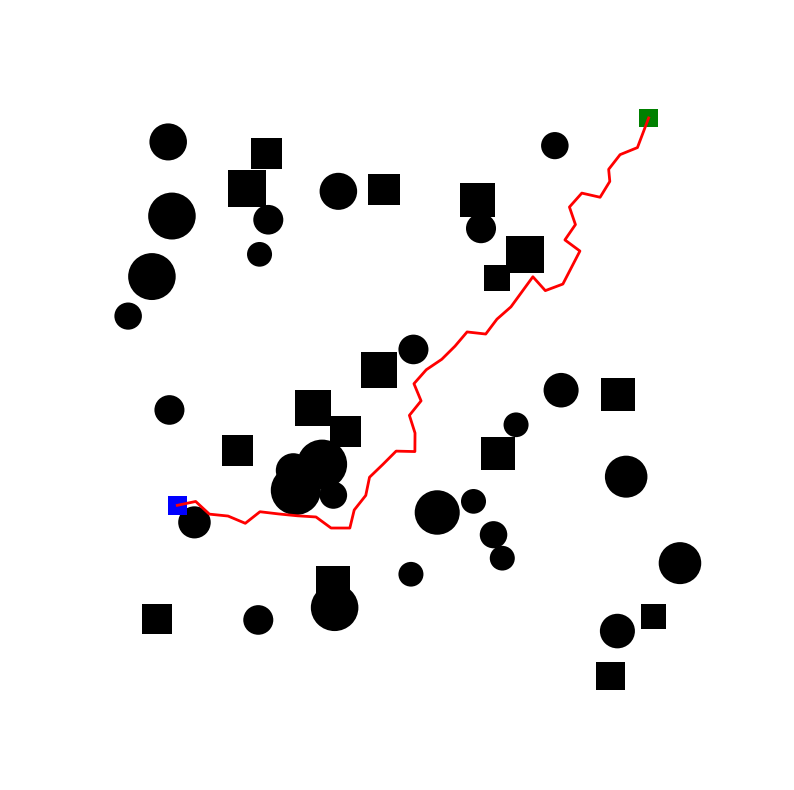

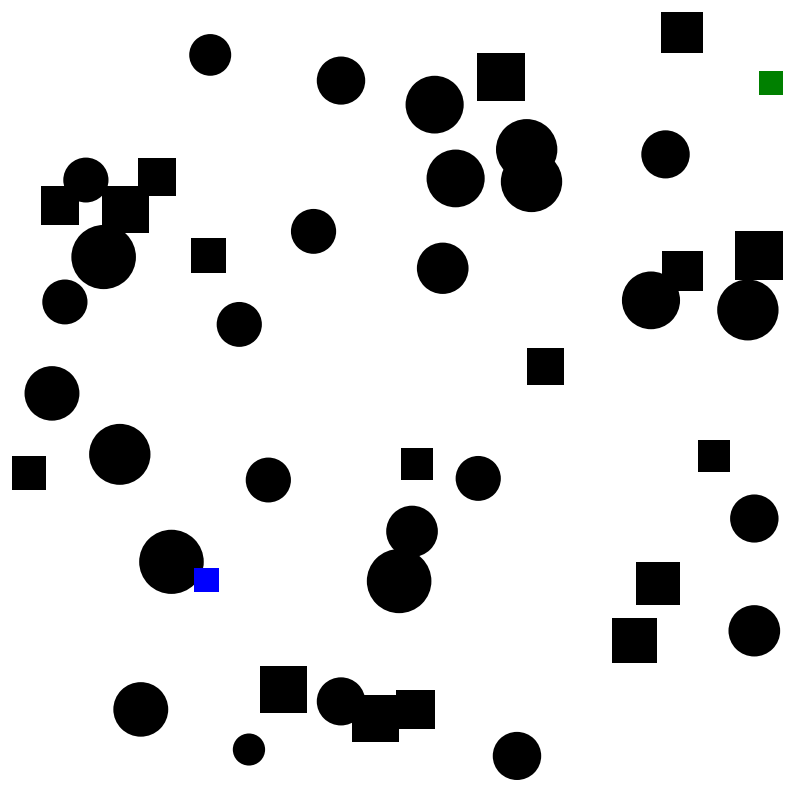

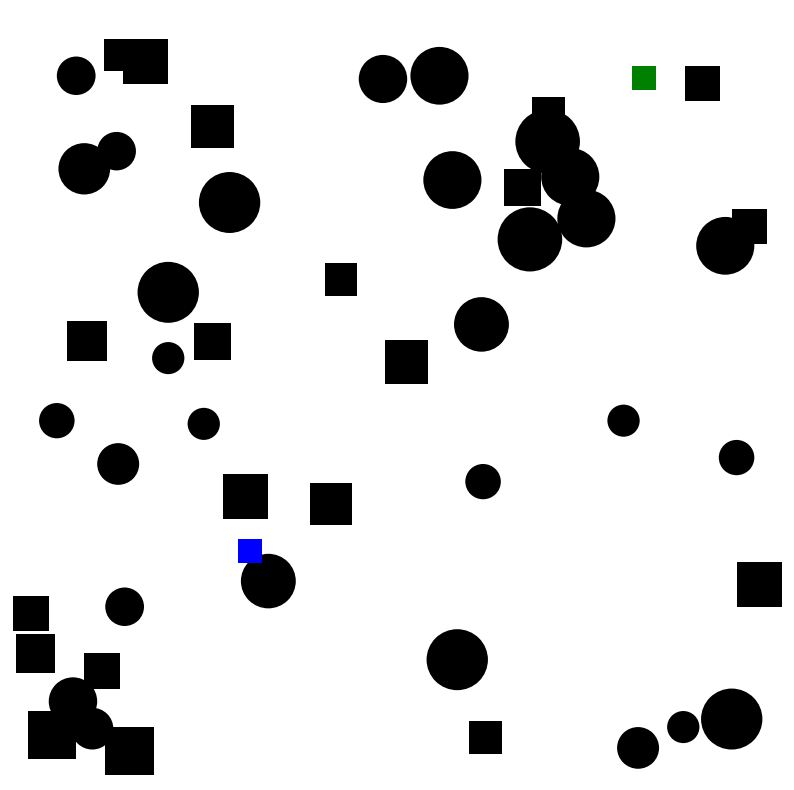

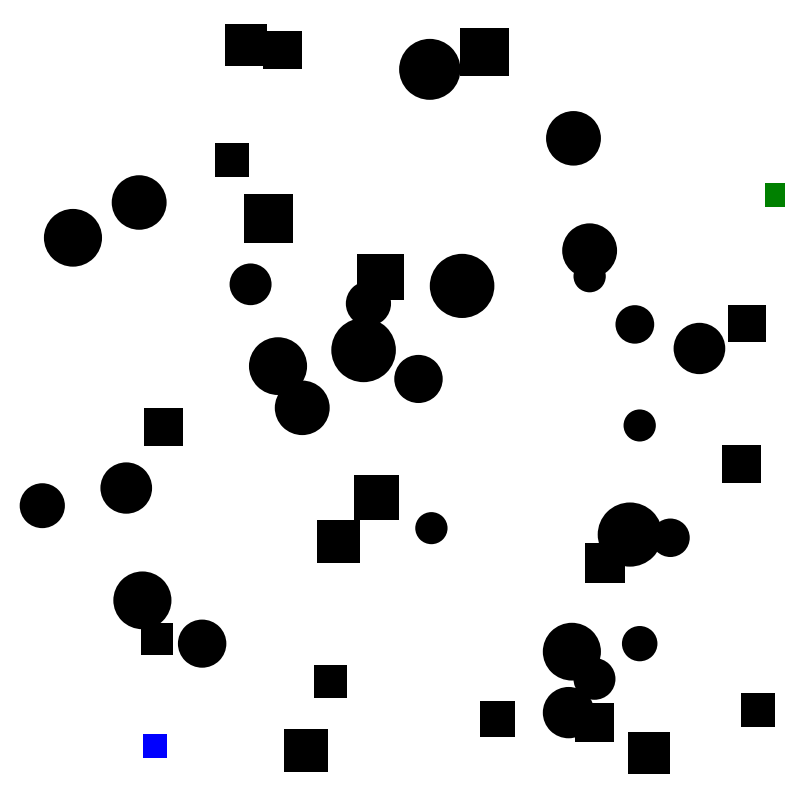

In [181]:
# prompt: 查看/content/output/coordinates和/content/output/maps有多少个文件

import os

coordinates_dir = "/content/output/coordinates"
maps_dir = "/content/output/maps"

coordinates_count = len([name for name in os.listdir(coordinates_dir) if os.path.isfile(os.path.join(coordinates_dir, name))])
maps_count = len([name for name in os.listdir(maps_dir) if os.path.isfile(os.path.join(maps_dir, name))])

print(f"Number of files in {coordinates_dir}: {coordinates_count}")
print(f"Number of files in {maps_dir}: {maps_count}")

# 删除文件

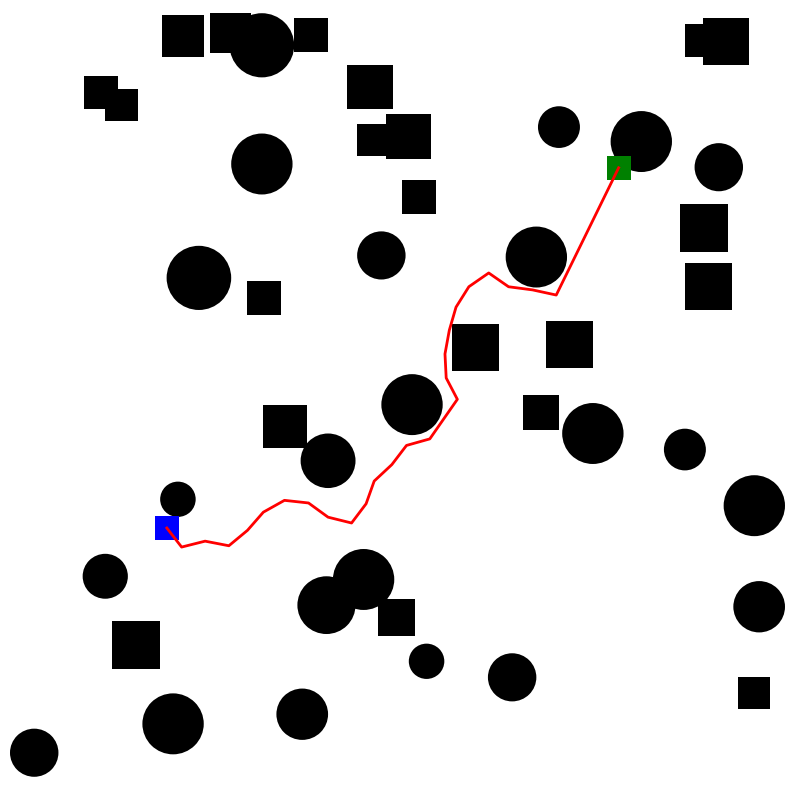

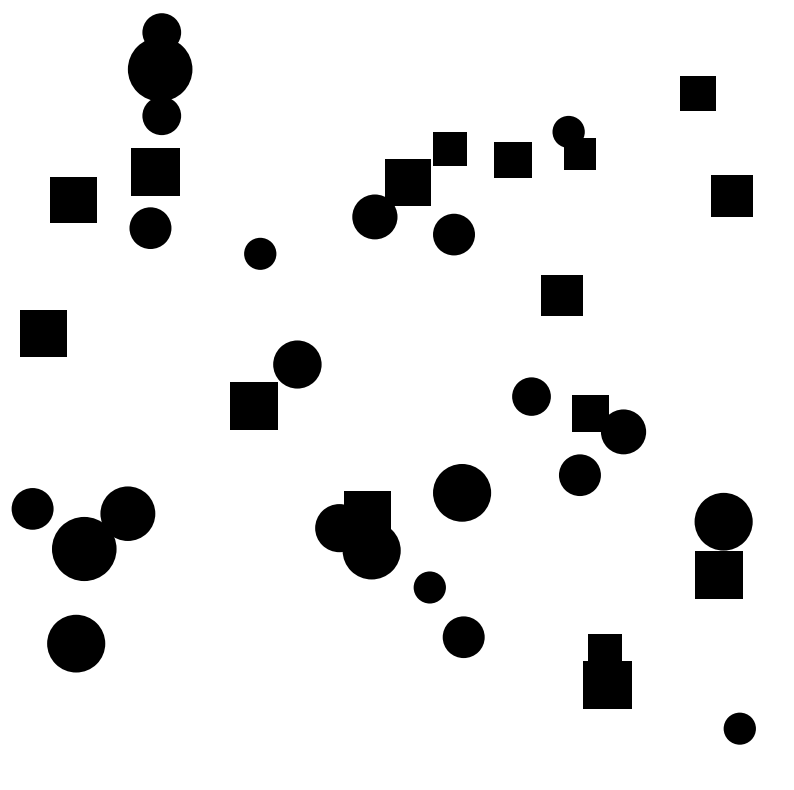

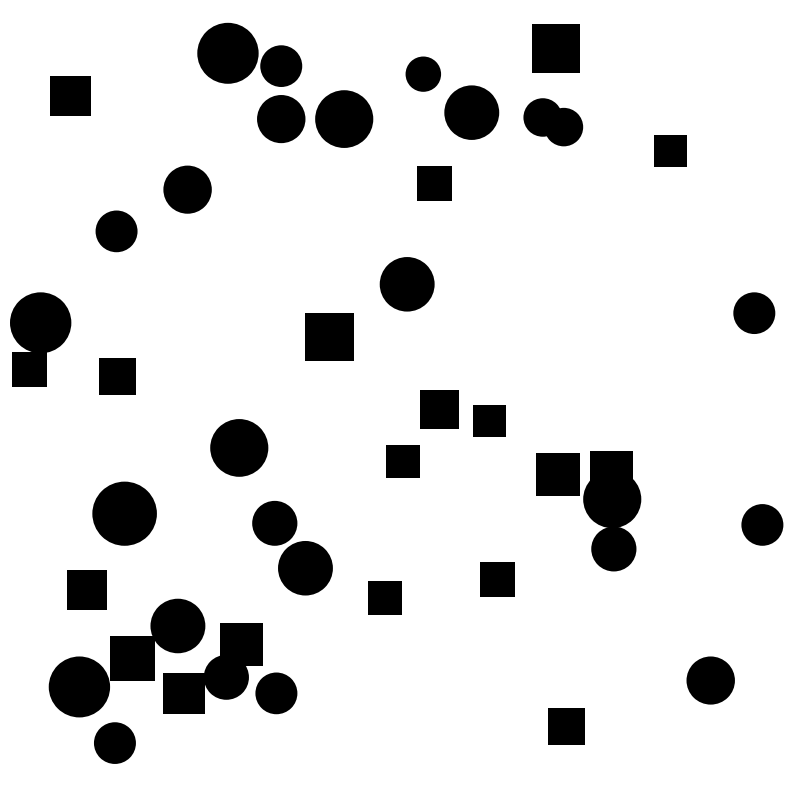

In [182]:
# prompt: 清空/content/output/coordinates和/content/output/maps文件夹

import shutil
import os

def delete_folder_contents(folder_path):
  """Deletes all files and subfolders within a given folder."""
  try:
    for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
          os.unlink(file_path)
        elif os.path.isdir(file_path):
          shutil.rmtree(file_path)
      except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
  except FileNotFoundError:
      print(f"Folder '{folder_path}' not found.")

# Delete contents of /content/output/coordinates
delete_folder_contents("/content/output/coordinates")

# Delete contents of /content/output/maps
delete_folder_contents("/content/output/maps")